In [1]:
import emission_line_flux
from emission_line_flux import get_emission_line_Flux
from emission_line_flux import _get_clipped_sed
from emission_line_flux import _quad_continuum_model
import dsps
from dsps import load_ssp_templates
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table
import numpy as np
from matplotlib import pyplot as plt

from jax import jit as jjit
from jax import grad
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm
from astropy.constants import L_sun
import astropy.constants as const

import astropy.units as u
import numpy.ma as ma

/Users/kumail/github/diff_warmup/emission_line_flux.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
ssp_data = load_ssp_templates(fn='tempdata.h5')

print(ssp_data._fields)

print('\nssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')

ssp_lgmet.shape = (12,)
ssp_lg_age_gyr.shape = (107,)
ssp_wave.shape = (5994,)
ssp_flux.shape = (12, 107, 5994)


In [4]:
gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr
gal_sfr_table = np.random.uniform(0, 10, gal_t_table.size) # SFR in Msun/yr

gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

In [5]:
print(DEFAULT_COSMOLOGY)

z_obs = 0.5
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

CosmoParams(Om0=0.3075, w0=-1.0, wa=0.0, h=0.6774)


In [6]:
sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

gal_lgmet_table = np.linspace(-3, -2, gal_t_table.size)

sed_info2 = calc_rest_sed_sfh_table_met_table(
    gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

In [7]:
continuum_fit_lo_lo = 6480
continuum_fit_lo_hi = 6530
continuum_fit_hi_lo = 6600
continuum_fit_hi_hi = 6650

halpha_line_center = 6562.8
halpha_line_lo = halpha_line_center-2
halpha_line_hi = halpha_line_center+6

In [8]:
losses, theta, sed_dict = get_emission_line_Flux(
                                                ssp_data.ssp_wave,
                                                sed_info.rest_sed,
                                                continuum_fit_lo_lo,
                                                continuum_fit_lo_hi,
                                                continuum_fit_hi_lo,
                                                continuum_fit_hi_hi,
                                                halpha_line_lo,
                                                halpha_line_center,
                                                halpha_line_hi
                                                )

  0%|          | 0/10000 [00:00<?, ?it/s]

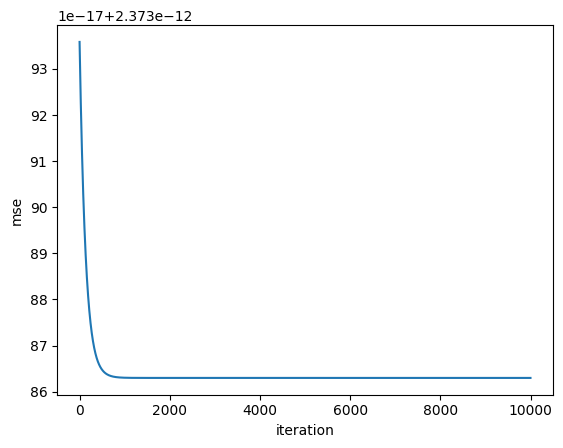

In [9]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

In [10]:
continuum_wave, continuum_rest_sed = _get_clipped_sed(ssp_data.ssp_wave, sed_info.rest_sed, continuum_fit_lo_lo, continuum_fit_hi_hi)

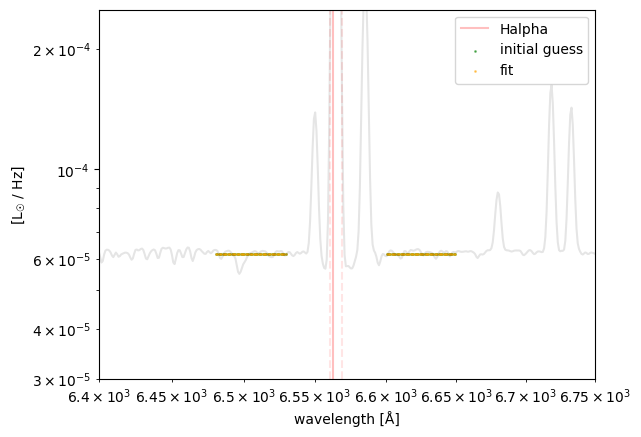

In [13]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed, alpha=0.1, c='k')


__=ax.axvline(halpha_line_lo, alpha=0.1, c='r', ls='--')
__=ax.axvline(halpha_line_center, label='Halpha', alpha=0.25, c='r')
__=ax.axvline(halpha_line_hi, alpha=0.1, c='r', ls='--')




#__=ax.plot(continuum_wave_masked, continuum_flux_true_masked, alpha=0.75, ls='--', c='k', label='masked continuum')

__=ax.scatter(sed_dict["continuum_wave_masked"], sed_dict["continuum_rest_sed_initial"], alpha=0.5, s=1, c='g', label='initial guess')


__=ax.scatter(sed_dict["continuum_wave_masked"], sed_dict["continuum_rest_sed_fit"], alpha=0.5, s=1, c='orange', label='fit')

#__=ax.scatter(continuum_wave, continuum_flux_fit_interp, alpha=1, s=0.1, c='r', label='fit (interpolated)')


__=ax.set_xlim(6.4e3,6.75e3)
__=ax.set_ylim(3e-5,2.5e-4)

__=ax.set_xlabel('wavelength [\u212b]')
__=ax.set_ylabel('[L$_{\u2609}$ / Hz]')

plt.legend()
plt.show()

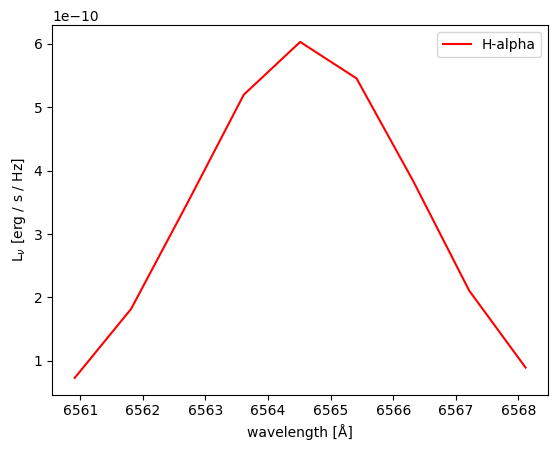

In [14]:
plt.plot(sed_dict["line_wave"], sed_dict["line_rest_sed_Fnu"], c='r', 
         label='H-alpha')

plt.xlabel('wavelength [\u212b]')
plt.ylabel('L$_{\u03bd}$ [erg / s / Hz]')
plt.legend()
plt.show()

In [15]:
sed_dict["integrated_line_rest_F"]

np.float64(-180.02174042203205)